In [ ]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Mengunggah file kaggle.json
uploaded = files.upload()

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/leukemia-classification --force

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/leukemia-classification
License(s): other
 24% 208M/867M [00:14<00:45, 15.3MB/s]
User cancelled operation


In [ ]:
!unzip leukemia-classification.zip

Archive:  leukemia-classification.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of leukemia-classification.zip or
        leukemia-classification.zip.zip, and cannot find leukemia-classification.zip.ZIP, period.


In [ ]:
DATASET_PATH = "/content/C-NMC_Leukemia"
TRAINING_PATH = os.path.join(DATASET_PATH, 'training_data')

# Path untuk folder0
TRAINING_ALL_PATH_0 = os.path.join(TRAINING_PATH, 'fold_0', 'all')
TRAINING_HEM_PATH_0 = os.path.join(TRAINING_PATH, 'fold_0', 'hem')

# Path untuk folder1
TRAINING_ALL_PATH_1 = os.path.join(TRAINING_PATH, 'fold_1', 'all')
TRAINING_HEM_PATH_1 = os.path.join(TRAINING_PATH, 'fold_1', 'hem')

# Path untuk folder2
TRAINING_ALL_PATH_2 = os.path.join(TRAINING_PATH, 'fold_2', 'all')
TRAINING_HEM_PATH_2 = os.path.join(TRAINING_PATH, 'fold_2', 'hem')

# Path untuk folder validasi
VALIDATION_PATH = os.path.join(DATASET_PATH, 'validation_data', 'C-NMC_test_prelim_phase_data')

# Path untuk folder pengujian
TEST_PATH = os.path.join(DATASET_PATH, 'testing_data', 'C-NMC_test_final_phase_data')


LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/models/vgg16"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [ ]:
# Fungsi untuk menetapkan seed
def set_seed():
    seed = 24
    os.environ["PYTHONHASHSEED"] = "0"
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)

# Fungsi untuk menampilkan performa training dan validasi
def show_training_and_validation_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Fungsi untuk memuat dataset training
def load_training_set(image_height, image_width, batch_size):
    return image_dataset_from_directory(
      os.path.join(TRAINING_PATH, 'fold_0'),  # Path ke folder fold_0
      image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
      batch_size=batch_size,
      shuffle=True,  # Anda bisa menentukan apakah ingin mengacak urutan dataset atau tidak
      seed=123,  # Seed untuk pengacakan
  )

# Fungsi untuk memuat dataset validasi
def load_validation_set(image_height, image_width, batch_size):
    return image_dataset_from_directory(
        os.path.join(DATASET_PATH, 'validation_data'),
        image_size=(image_height, image_width),
        batch_size=batch_size,  # Gunakan parameter batch_size yang diteruskan
        shuffle=True,  # Anda bisa menentukan apakah ingin mengacak urutan dataset atau tidak
        seed=123,  # Seed untuk pengacakan
    )

# Fungsi untuk memuat dataset uji
def load_test_set(image_height, image_width, batch_size):
    return image_dataset_from_directory(
      os.path.join(DATASET_PATH, 'testing_data'),
      image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
      batch_size=batch_size,
      shuffle=True,
      seed=123,
  )


# Fungsi untuk mengompilasi model
def compile_model(model, optimizer='adam', learning_rate=0.001):
    if optimizer == 'adam':
        model.compile(loss="binary_crossentropy",
                      optimizer=optimizers.Adam(learning_rate=learning_rate),
                      metrics=["accuracy"])
    elif optimizer == 'rmsprop':
        model.compile(loss="binary_crossentropy",
                      optimizer=optimizers.RMSprop(learning_rate=learning_rate),
                      metrics=['accuracy'])
    model.summary()

# Fungsi untuk menjalankan model
def run_model (model, model_name, train_dataset, validation_dataset, epochs = 20, patience=5, monitor='val_loss'):
    save_path = os.path.join(LOCAL_MODELS_FOLDER, model_name + '.h5')
    callbacks_list = [
        EarlyStopping(monitor=monitor, patience=patience),
        ModelCheckpoint(
            filepath=save_path,
            monitor=monitor,
            verbose=1,
            save_best_only=True
        )
    ]
    history = model.fit(train_dataset,
                        epochs=epochs,
                        validation_data=validation_dataset,
                        callbacks=callbacks_list)
    shutil.copy(save_path, os.path.join(GLOBAL_MODELS_FOLDER, model_name + '.h5'))
    show_training_and_validation_performance(history)


def evaluate_model(model):
    '''
    evaluate_model is used to plot some statistics about the performance on the test set
    :param model: model to consider
    '''
    y_score = model.predict(test_dataset)
    y_pred = np.rint(y_score) # to have 0 or 1
    y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis=0)

    # Print classification report
    print("Classification report: ")
    print(metrics.classification_report(y_true, y_pred, digits=4))

    # Print confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
set_seed()

In [ ]:
# Hitung jumlah gambar dalam folder training untuk "all" dan "hem"
num_all_tr_0 = len(os.listdir(TRAINING_ALL_PATH_0))
num_hem_tr_0 = len(os.listdir(TRAINING_HEM_PATH_0))

num_all_tr_1 = len(os.listdir(TRAINING_ALL_PATH_1))
num_hem_tr_1 = len(os.listdir(TRAINING_HEM_PATH_1))

num_all_tr_2 = len(os.listdir(TRAINING_ALL_PATH_2))
num_hem_tr_2 = len(os.listdir(TRAINING_HEM_PATH_2))

# Hitung jumlah gambar dalam folder validasi
num_all_val = len(os.listdir(VALIDATION_PATH))

# Total gambar untuk training dan validasi
total_train = num_all_tr_0 + num_hem_tr_0 + num_all_tr_1 + num_hem_tr_1 + num_all_tr_2 + num_hem_tr_2
total_val = num_all_val

FileNotFoundError: [Errno 2] No such file or directory: '/content/C-NMC_Leukemia/training_data/fold_0/all'

In [ ]:
print('Total training images:', total_train)
print('Total training images fold 0 (all):', num_all_tr_0)
print('Total training images fold 0 (hem):', num_hem_tr_0)
print('Total training images fold 1 (all):', num_all_tr_1)
print('Total training images fold 1 (hem):', num_hem_tr_1)
print('Total training images fold 2 (all):', num_all_tr_2)
print('Total training images fold 2 (hem):', num_hem_tr_2)
print('Total validation images:', num_all_val)

Total training images: 10661
Total training images fold 0 (all): 2397
Total training images fold 0 (hem): 1130
Total training images fold 1 (all): 2418
Total training images fold 1 (hem): 1163
Total training images fold 2 (all): 2457
Total training images fold 2 (hem): 1096
Total validation images: 1867


In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32

train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 3527 files belonging to 2 classes.
Found 1867 files belonging to 1 classes.
Found 2586 files belonging to 1 classes.


In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
conv_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vanilla_vgg_model = keras.Model(inputs, outputs)
compile_model(vanilla_vgg_model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422

Epoch 1/100
111/111 [==============================] - ETA: 0s - loss: 9.1399 - accuracy: 0.7709
Epoch 1: val_loss improved from inf to 14.65732, saving model to /content/models/experiment1_feature_extraction_vanilla.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - 41s 256ms/step - loss: 9.1399 - accuracy: 0.7709 - val_loss: 14.6573 - val_accuracy: 0.3680
Epoch 2/100
110/111 [============================>.] - ETA: 0s - loss: 1.8428 - accuracy: 0.8452
Epoch 2: val_loss improved from 14.65732 to 0.81535, saving model to /content/models/experiment1_feature_extraction_vanilla.h5
111/111 [==============================] - 22s 195ms/step - loss: 1.8396 - accuracy: 0.8452 - val_loss: 0.8153 - val_accuracy: 0.8881
Epoch 3/100
110/111 [============================>.] - ETA: 0s - loss: 0.7087 - accuracy: 0.8739
Epoch 3: val_loss did not improve from 0.81535
111/111 [==============================] - 21s 191ms/step - loss: 0.7134 - accuracy: 0.8733 - val_loss: 0.9017 - val_accuracy: 0.8602
Epoch 4/100
111/111 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.9059
Epoch 4: val_loss did not improve from 0.81535
111/111 [==============================] - 22s 196ms/step - loss: 0.3859 - accuracy: 

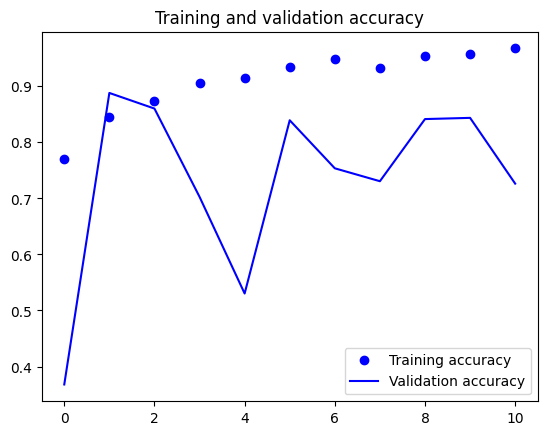

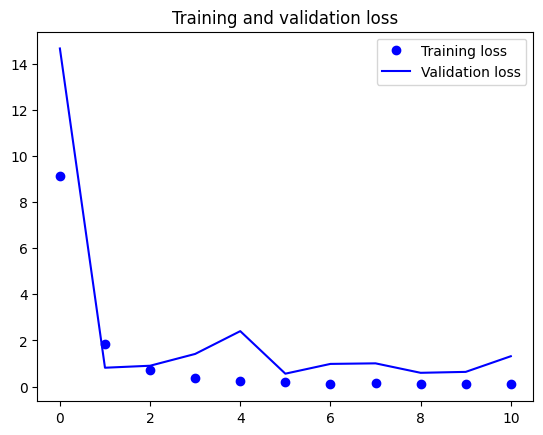

In [ ]:
run_model(vanilla_vgg_model, 'experiment1_feature_extraction_vanilla', train_dataset, validation_dataset, epochs=100, patience=5, monitor='val_loss')

81/81 [==============================] - 11s 125ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.2846    0.4431      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.2846      2586
   macro avg     0.5000    0.1423    0.2216      2586
weighted avg     1.0000    0.2846    0.4431      2586

Confusion Matrix:
[[ 736 1850]
 [   0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


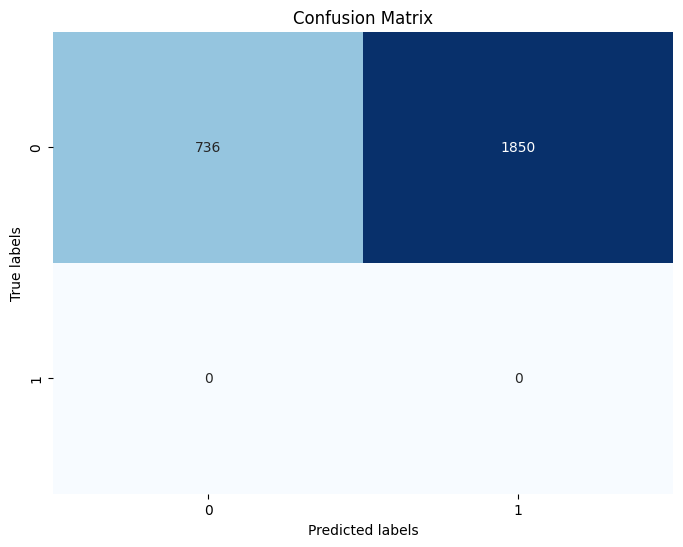

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction_vanilla.h5'))

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
dropout_vgg_model = keras.Model(inputs, outputs)
compile_model(dropout_vgg_model)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422

Epoch 1/100
111/111 [==============================] - ETA: 0s - loss: 11.4519 - accuracy: 0.7576
Epoch 1: val_loss improved from inf to 0.43736, saving model to /content/models/experiment2_feature_extraction_dropout.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - 32s 238ms/step - loss: 11.4519 - accuracy: 0.7576 - val_loss: 0.4374 - val_accuracy: 0.9679
Epoch 2/100
111/111 [==============================] - ETA: 0s - loss: 6.3603 - accuracy: 0.8083
Epoch 2: val_loss did not improve from 0.43736
111/111 [==============================] - 27s 229ms/step - loss: 6.3603 - accuracy: 0.8083 - val_loss: 3.1275 - val_accuracy: 0.8779
Epoch 3/100
111/111 [==============================] - ETA: 0s - loss: 3.9932 - accuracy: 0.8353
Epoch 3: val_loss did not improve from 0.43736
111/111 [==============================] - 23s 204ms/step - loss: 3.9932 - accuracy: 0.8353 - val_loss: 6.3143 - val_accuracy: 0.6443
Epoch 4/100
111/111 [==============================] - ETA: 0s - loss: 2.7030 - accuracy: 0.8460
Epoch 4: val_loss did not improve from 0.43736
111/111 [==============================] - 22s 194ms/step - loss: 2.7030 - accuracy: 0.8460 - val_loss: 1.1984 - val_accuracy: 0.8870
Epoch 5/100
111/111 [==========

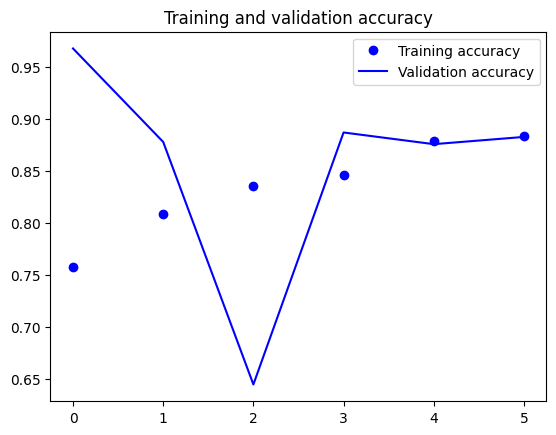

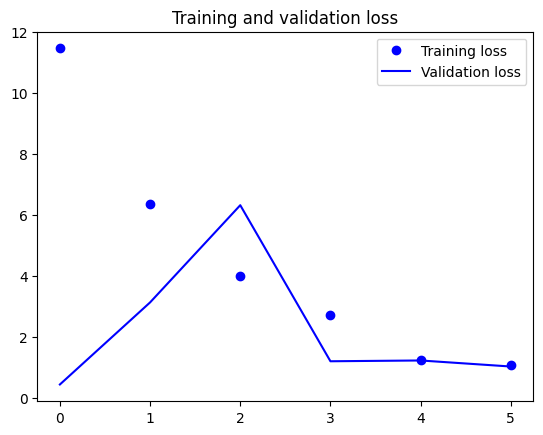

In [ ]:
run_model(dropout_vgg_model, 'experiment2_feature_extraction_dropout', train_dataset, validation_dataset, epochs = 100, patience=5, monitor='val_loss')

81/81 [==============================] - 18s 195ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.4401    0.6112      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.4401      2586
   macro avg     0.5000    0.2200    0.3056      2586
weighted avg     1.0000    0.4401    0.6112      2586

Confusion Matrix:
[[1138 1448]
 [   0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


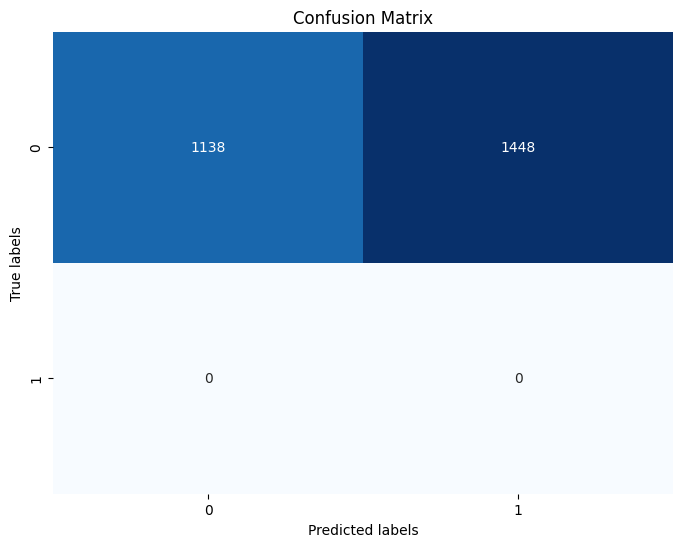

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment2_feature_extraction_dropout.h5'))

In [ ]:
inputs = keras.Input(shape=(224,224,3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
global_average = keras.Model(inputs, outputs)
compile_model(global_average)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_4 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/100
111/111 [==============================] - ETA: 0s - loss: 0.8271 - accuracy: 0.7448
Epoch 1: val_loss improved from inf to 0.39620, saving model to /content/models/experiment3_feature_extraction_gap.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - 30s 240ms/step - loss: 0.8271 - accuracy: 0.7448 - val_loss: 0.3962 - val_accuracy: 0.8141
Epoch 2/100
111/111 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.7925
Epoch 2: val_loss improved from 0.39620 to 0.33000, saving model to /content/models/experiment3_feature_extraction_gap.h5
111/111 [==============================] - 23s 202ms/step - loss: 0.5474 - accuracy: 0.7925 - val_loss: 0.3300 - val_accuracy: 0.8554
Epoch 3/100
110/111 [============================>.] - ETA: 0s - loss: 0.4875 - accuracy: 0.8045
Epoch 3: val_loss did not improve from 0.33000
111/111 [==============================] - 22s 192ms/step - loss: 0.4874 - accuracy: 0.8044 - val_loss: 0.9135 - val_accuracy: 0.5394
Epoch 4/100
111/111 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.8021
Epoch 4: val_loss improved from 0.33000 to 0.29855, saving model to /content/models/experiment3_feature_extraction_gap.h5
111/111 [=======

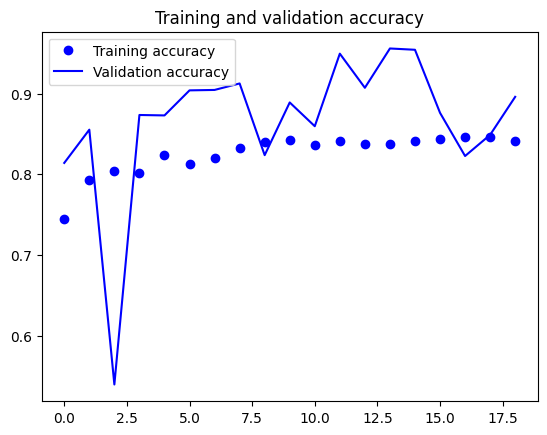

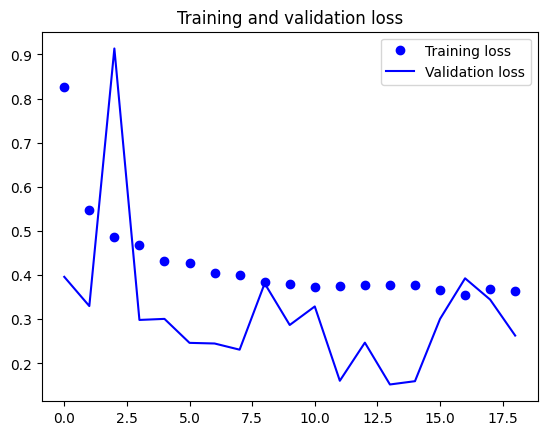

In [ ]:
run_model(global_average, 'experiment3_feature_extraction_gap', train_dataset, validation_dataset, epochs = 100, patience=5, monitor='val_loss')

81/81 [==============================] - 11s 122ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.4459    0.6167      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.4459      2586
   macro avg     0.5000    0.2229    0.3084      2586
weighted avg     1.0000    0.4459    0.6167      2586

Confusion Matrix:
[[1153 1433]
 [   0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


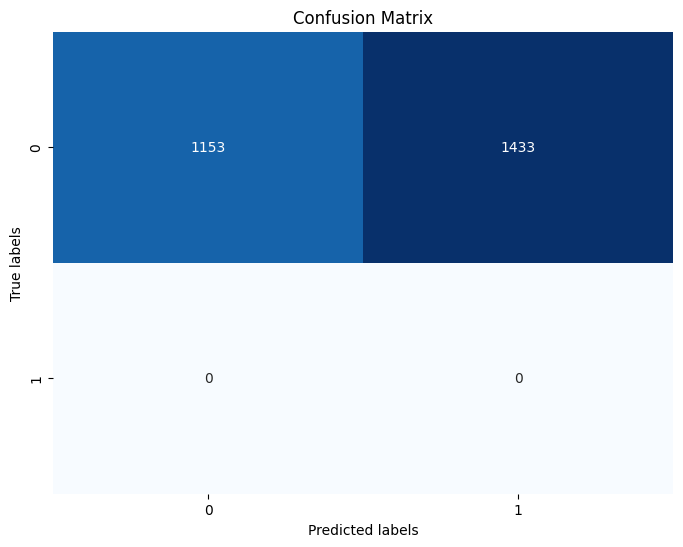

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment3_feature_extraction_gap.h5'))

In [ ]:
vgg_ft_1_layer = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment2_feature_extraction_dropout.h5'))

for layer in vgg_ft_1_layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(vgg_ft_1_layer, learning_rate=1e-5)

for i, layer in enumerate(vgg_ft_1_layer.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422

Epoch 1/100
111/111 [==============================] - ETA: 0s - loss: 3.7490 - accuracy: 0.8268
Epoch 1: val_loss improved from inf to 1.79560, saving model to /content/models/experiment4_finetuning_1_layer.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


111/111 [==============================] - 26s 207ms/step - loss: 3.7490 - accuracy: 0.8268 - val_loss: 1.7956 - val_accuracy: 0.8709
Epoch 2/100
111/111 [==============================] - ETA: 0s - loss: 2.4489 - accuracy: 0.8452
Epoch 2: val_loss did not improve from 1.79560
111/111 [==============================] - 23s 203ms/step - loss: 2.4489 - accuracy: 0.8452 - val_loss: 3.1797 - val_accuracy: 0.7713
Epoch 3/100
111/111 [==============================] - ETA: 0s - loss: 1.6609 - accuracy: 0.8710
Epoch 3: val_loss did not improve from 1.79560
111/111 [==============================] - 23s 203ms/step - loss: 1.6609 - accuracy: 0.8710 - val_loss: 1.9801 - val_accuracy: 0.8281
Epoch 4/100
111/111 [==============================] - ETA: 0s - loss: 1.2603 - accuracy: 0.8795
Epoch 4: val_loss improved from 1.79560 to 1.65929, saving model to /content/models/experiment4_finetuning_1_layer.h5
111/111 [==============================] - 23s 209ms/step - loss: 1.2603 - accuracy: 0.8795 - v

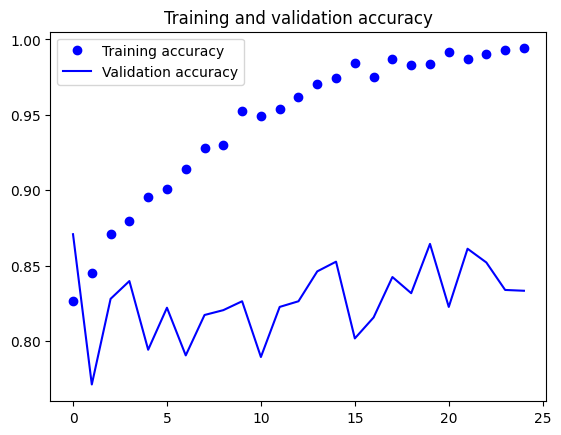

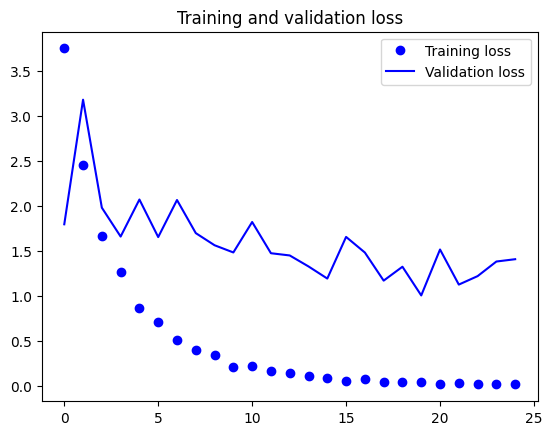

In [ ]:
run_model(vgg_ft_1_layer, 'experiment4_finetuning_1_layer', train_dataset, validation_dataset, epochs = 100, patience=5, monitor='val_loss')

81/81 [==============================] - 13s 138ms/step
Classification report: 
              precision    recall  f1-score   support

         0.0     1.0000    0.3337    0.5004      2586
         1.0     0.0000    0.0000    0.0000         0

    accuracy                         0.3337      2586
   macro avg     0.5000    0.1669    0.2502      2586
weighted avg     1.0000    0.3337    0.5004      2586

Confusion Matrix:
[[ 863 1723]
 [   0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


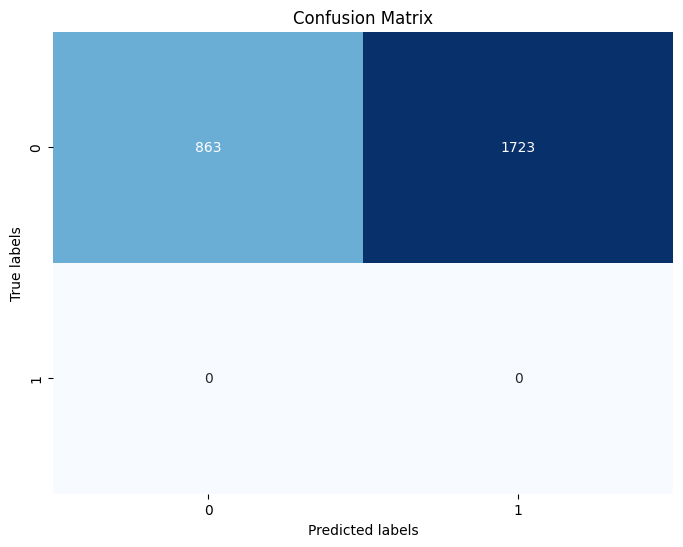

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4_finetuning_1_layer.h5'))